<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/3.4-biLSTMB-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi-directional LSTM Prototype (Balanced Weights)

LSTM is generally doing pretty good in our deep learning models. In our last notebook, we ran LSTM network with default weights - ie, penalty for mis-classification is the same across all classes.

In this notebook, we will use 'balanced' weights calculated by sklearn's compute_class_weight so that we put more emphasis on our minority classes for our predictions to see if this improves the performanced of our model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
import tensorflow.keras.layers as layers
import tensorflow.keras as keras


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


MODEL_NAME = "bi-LSTMB"
LSTM_DIM = 64 # total LSTM units
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer Bidirectional {LSTM_DIM} LSTM Units and 20% 1D Spatial Dropout - Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 8

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-200k-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Vocabulary size=45009
Number of Documents=149350
Train review vectors shape: (149350, 100)  Test review vectors shape: (49784, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1


# building our network
# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(5, activation="softmax"))

# use functional syntax to create our graph
inp = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = Embedding(vocab_size, EMBED_SIZE, trainable=True)(inp)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dropout(0.2)(x)
outp = Dense(5, activation='softmax')(x)

model = keras.models.Model(inputs=inp, outputs=outp)
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          13503000  
_________________________________________________________________
dropout (Dropout)            (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 13,690,525
Trainable params: 13,690,525
Non-trainable params: 0
_________________________________________________

In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, reduce_lr])

class weights: [1.43633872 3.07851898 2.18840596 1.19528211 0.3723871 ]
Number of training examples: 149350
Train on 119480 samples, validate on 29870 samples
Epoch 1/50
119480/119480 [==============================] - 390s 3ms/sample - loss: 0.9234 - categorical_accuracy: 0.6465 - val_loss: 0.8436 - val_categorical_accuracy: 0.6759
Epoch 2/50
119480/119480 [==============================] - 391s 3ms/sample - loss: 0.7981 - categorical_accuracy: 0.6884 - val_loss: 0.8224 - val_categorical_accuracy: 0.6822
Epoch 3/50
119480/119480 [==============================] - 390s 3ms/sample - loss: 0.7372 - categorical_accuracy: 0.7128 - val_loss: 0.8227 - val_categorical_accuracy: 0.6841
Epoch 4/50
119480/119480 [==============================] - 383s 3ms/sample - loss: 0.6827 - categorical_accuracy: 0.7364 - val_loss: 0.8444 - val_categorical_accuracy: 0.6791
Epoch 00004: early stopping


Number of test: 49784
Running model.evaluate...
49784/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

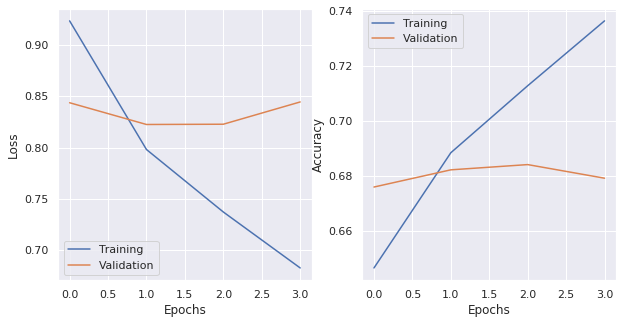


Confusion Matrix
[[ 5672   409   421    85   394]
 [ 1703   412   668   150   292]
 [  969   353  1611   675   932]
 [  381   126  1129  2175  4487]
 [  474    92   636  1667 23871]]

Classification Report
              precision    recall  f1-score   support

           1       0.62      0.81      0.70      6981
           2       0.30      0.13      0.18      3225
           3       0.36      0.35      0.36      4540
           4       0.46      0.26      0.33      8298
           5       0.80      0.89      0.84     26740

    accuracy                           0.68     49784
   macro avg       0.51      0.49      0.48     49784
weighted avg       0.64      0.68      0.65     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:252: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:256: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

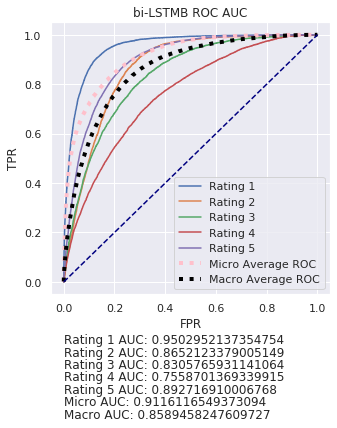

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.2950287626633878


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: bi-LSTMB-1x64-random_embedding-sampling_none-199134-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/bi-LSTMB-1x64-random_embedding-sampling_none-199134-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/bi-LSTMB-1x64-random_embedding-sampling_none-199134-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/bi-LSTMB-1x64-random_embedding-sampling_none-199134-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2019-11-dl_prototype-report.csv
{'model_name': 'bi-LSTMB', 'architecture': '1x64', 'description': '1 Layer Bidirectional 64 LSTM Units and 20% 1D Spatial Dropout - Balanced Weights', 'classification_report': '{"1": {"precision": 0.6165887596477878, "recall": 0.8124910471279186, "f1-score": 0.7011124845488257, "support": 698

In [11]:
print(datetime.now())

2019-11-09 01:06:58.203789
